Here I will show how I process raw experimental data stored in binary files, containing millions of data points. For simplicity, I will use a file containing over 10 million data points, which were recorded during approximately 35 minutes. However, a typical magnetic tweezers experiment can last for several hours, so the files I usually need to process are much bigger than the one I used here.

During a typical magnetic tweezers experiment, four parameters are recorded: the extension of the protein (in nm), the force applied to the protein (in pN), the absolute time (in s) and the position of the magnet.

First, I read a binary file to an array, which I convert into a data frame.

As you can see, the data frame contains only one column which includes all the recorded data. In this data, every point number 2+4n corresponds to an absolute time in seconds. Note, that this file had been recorded from the moment when time=20701.041016 seconds.

Every point number 0+4n is the extension of the protein (in nm) measured in the moment when time = point 2+4n Every point number 1+4n is the force applied to the protein at each moment of time. Finally, every point number 3+4n represents the position of the magnet.

For example, as you can see in the output below, points number 12 and number 16 are two measured extensions of the protein, 16.355019 nm and 6.418248 nm, and these two measurements were done when time = 20701.041016 sec (point number 14) and time = 20701.042969 sec (point number 18) respectively.

In [1]:
import numpy as np
import pandas as pd

File ='MT3Data_bin'
Trace = np.fromfile(File, dtype=np.float32, sep='')  #Trace contains extension, time, force, and magnet position (or current) data.

Nmpnts=len(Trace)# calculating the total number of points in the file

df = pd.DataFrame(Trace, columns=Trace.dtype.names)

print("Number of points: "+str(Nmpnts))
df.head(20)

Number of points: 10573764


,0
0,20.755337
1,4.030497
2,20701.041016
3,186.619186
4,13.835124
5,4.030542
6,20701.041016
7,186.620865
8,12.065634
9,4.030542


First, we need to clean the data.

Let me visualize below the behaviour of the protein extension throughout the experiment. As you can see, during almost the whole duration of the experiment, the extension of the protein was changing between 0 and 100 nm, but, in the end of the experiment, this parameter dropped drastically till -800 nm.

Note, that these values of extension are relative to some initial extension in nm, so in principle they can be negative. Obviously, the 800 nm difference between the initial values of the extension and the ones we observe towards the end of the experiment does not make sense. This change of extension is due to the fact that the experiment got disrupted, and all the data starting from that moment is not representative.

Text(0.5, 0, 'points')

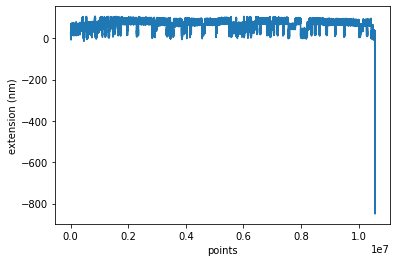

In [2]:
import matplotlib.pyplot as plt

#Magic command to display plots
%matplotlib inline 

plt.plot(df[0:Nmpnts:4])  #Plot extension vs number of points along the entire length of the Trace vector. Every 4 positions from the beginning you find an extension data point.
plt.ylabel('extension (nm)')
plt.xlabel('points')

We can delete these non-representative data by removing the needed amount of rows from tail of the data frame.

Text(0.5, 0, 'points')

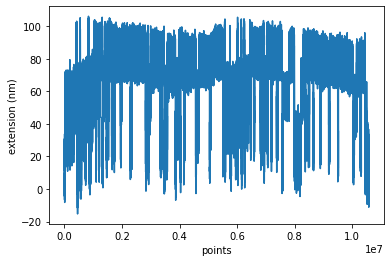

In [3]:
df.drop(df.tail(1040).index,inplace=True) # drop last n rows, cleaning the data after the point at wich the experiment got disrupted

plt.plot(df[0:Nmpnts:4])  #Plot extension vs number of points along the entire length of the Trace vector. Every 4 positions from the beginning you find an extension data point.
plt.ylabel('extension (nm)')
plt.xlabel('points')

Look at how the protein extension behaves now. These data make much more sense.

In my opinion, it is very difficult to work with a data frame that contains values corresponding to different types of parameters stored in the same column.

To make the data more comfortable to work with, we can create a new data frame with four columns, each of them containing the values of the corresponding parameter.

In [4]:
new_n_points=round(Nmpnts/4)# calculation the number of rows in the new data frame

#setting empty lists for data corresponding to extension, force, time and magnet position correspondingly
col0=[]
col1=[]
col2=[]
col3=[]

#setting the initial index values
a0=0
a1=1
a2=2
a3=3

#building four new data frames, each of them containing one column with the corresponding parameter
for i in range(new_n_points):
    col0.append(Trace[a0])
    col1.append(Trace[a1])
    col2.append(Trace[a2])
    col3.append(Trace[a3])
    a0=a0+4
    a1=a1+4
    a2=a2+4
    a3=a3+4

#setting the names of the columns accordingly to the parameter they represent
df0 = pd.DataFrame (col0, columns = ['extension'])
df1 = pd.DataFrame (col1, columns = ['force'])
df2 = pd.DataFrame (col2-col2[0], columns = ['time'])# here we set the initial time to 0 seconds so the data can be read in a more comprehensive way
df3 = pd.DataFrame (col3, columns = ['magnet position'])

#merging the four data frames into a unique data frame containing all the parameters
dat= pd.concat([df0, df1,df2,df3],axis=1,join='inner')

dat.head(10)

,extension,force,time,magnet position
0,20.755337,4.030497,0.000000,186.619186
1,13.835124,4.030542,0.000000,186.620865
2,12.065634,4.030542,0.000000,186.620865
3,16.355019,4.032350,0.000000,186.688339
4,6.418248,4.032350,0.001953,186.688339
5,8.395434,4.032699,0.001953,186.701355
6,4.543797,4.030675,0.001953,186.625824
7,2.815779,4.030675,0.001953,186.625824
8,9.318281,4.030717,0.003906,186.627396
9,15.117812,4.032041,0.003906,186.676788


Now it is more convenient to work with the experimental data, let's play with it!

Protein molecules are polymers. Upon application of force, the extension of a protein molecule increases because of a simple stretching (just like the extension of a spring increments if we pull on it).

Additionally, mechanical force applied to a protein can also provoke unfolding of the protein 3D structure. In this case, the extension of the protein will gain an additional increment.

Let's take a look at the first 20 seconds of the experiment:

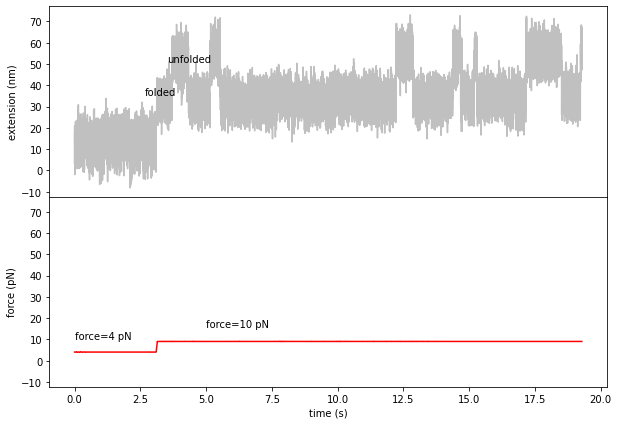

In [5]:
#Setting the interval of the data we want to plot
#dat.drop(dat.head(1410000).index,inplace=True)#drop first n rows if you want
dat.drop(dat.tail(2620000).index,inplace=True) # drop last n rows to exclude the points of extreme extension 

#Creating two sublots: the one showing the change in protein's extension over time,
#and the one showing the change in applied forceo over time.
fig, f = plt.subplots(2,1,sharex=True,sharey=True,figsize=(10,7))
f[0].plot(dat.iloc[:,2],dat.iloc[:,0],color='silver')
f[0].set(ylabel='extension (nm)')
f[0].text(0.2, 0.55, 'folded', horizontalalignment='center', verticalalignment='center', transform=f[0].transAxes)
f[0].text(0.25, 0.72, 'unfolded', horizontalalignment='center', verticalalignment='center', transform=f[0].transAxes)

f[1].plot(dat.iloc[:,2],dat.iloc[:,1],color='red')
plt.xlabel('time (s)')
f[1].set(ylabel='force (pN)')

plt.text(0,10,'force=4 pN')
plt.text(5,16,'force=10 pN')
fig.subplots_adjust(hspace=0)

First, look at the sublot at the bottom. It shows how the applied force changed during the first 20 seconds of the experiment.
After approximately 3 seconds from the start of the experiment, the force changed from 4 pN to 10 pN.

Now let's look at the subplot at the top. In the moment, in which the force increases, the extension of the protein also increases (from 10 to 30 nm approximately). This is due to the mechanical elastic stretching of the protein.

But then after a few moments, we see another increment in the protein's extension (from 30 to 50 nm) which is followed by the return of the extension to the previous position. Later on, the protein molecule's extension increases and decreases again and again. These increments and drops of extension at are due to the unfolding and folding of the protein's 3D structure.

When the protein unfolds, we observe an increment in extension, when the protein folds back, we see the protein's extension shorten to the previous level. Thus, at 10 pN, the protein is found in the equilibrium between these two states: folded and unfolded.


The data we are working with here does not have any drift, i.e. the measured extension signal is flat. However, this not always the case. In many cases, for the reasons explained here (DOI: 10.1146/annurev-biophys-122311-100544), the extension recorded during an experiment drifts (it is consistently over- or underestimated, so the extension signal looks positively or negatively tilted).

Now I will simulate a positive drift of the extension data from our experiment by tilting the ‘extension’ column from our ‘dat’ data frame and I will create a new data frame with the simulated  drifted extension data instead of the original extension data.

In [7]:
dat_drift=dat.drop(['extension'],axis=1)

for i in range(dat_drift.shape[0]):
    dat_drift.loc[i,'simulated_drifted_extension']=dat.loc[i,'extension']+0.00009*i*dat.loc[0,'extension']

dat_drift.head(10)

,force,time,magnet position,simulated_drifted_extension
0,4.030497,0.000000,186.619186,20.755337
1,4.030542,0.000000,186.620865,13.836992
2,4.030542,0.000000,186.620865,12.069370
3,4.032350,0.000000,186.688339,16.360623
4,4.032350,0.001953,186.688339,6.425720
5,4.032699,0.001953,186.701355,8.404774
6,4.030675,0.001953,186.625824,4.555004
7,4.030675,0.001953,186.625824,2.828855
8,4.030717,0.003906,186.627396,9.333225
9,4.032041,0.003906,186.676788,15.134624


Look at the plot below. The extension signal is tilted.

Text(0.5, 0, 'time (s)')

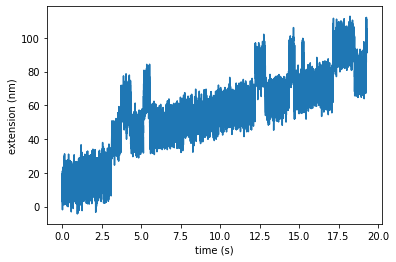

In [8]:
plt.plot(dat_drift['time'],dat_drift['simulated_drifted_extension'])
plt.ylabel('extension (nm)')
plt.xlabel('time (s)')

We cannot use this data for analysis, since we will not be able to correctly assign levels for the extension. To proceed to data analysis, we need to correct the drift of the extension.
We can do it by finding the velocity of the drift, i.e., the tangents of the angle between the trend of the extension and line parallel to the x axis. Then, we need to manipulate the drifted extension data so it is rotated to the desirable flat signal.

To find the velocity of the extension drift, we will fit this data with a linear model kx+b, where x is time. The coefficient k is the velocity of the drift and is the tangents of the angle between the drift trend and the horizontal axis. 

In [9]:
import statsmodels.formula.api as sm 

####m_drift :a linear model to estimate the velocity of the drift, kx+b ####################
results_m_drift=sm.ols('simulated_drifted_extension ~ time', data=dat_drift).fit()

#Saving parameters for the m_drift (lienear model): b and k
parameters_m_drift=results_m_drift.params

print("parameter b: " + str(parameters_m_drift[0])+"   parameter k: "+ str(parameters_m_drift[1]))

parameter b: 21.583820561470034   parameter k: 3.5518489575670342


Let me plot the obtained linear model. As you can see, it describes quite accurately the drift of the extension. 

Text(0.5, 0, 'time (s)')

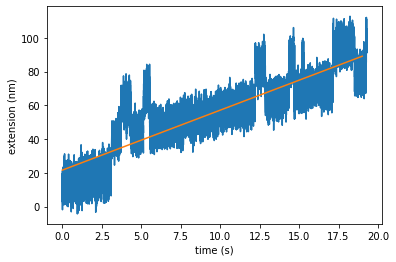

In [10]:
#Here I simulate the line that represents our linear model
x =  np.array(range(0,20))
y = parameters_m_drift['time']*x+parameters_m_drift['Intercept']

#Plotting the drifted extension vs. time together with the linear model
plt.plot(dat_drift['time'],dat_drift['simulated_drifted_extension'])
plt.plot(x,y)
plt.ylabel('extension (nm)')
plt.xlabel('time (s)')

Now, knowing the velocity of the drift, we can corrected the observed extension data.

In [11]:
#Creating a new data frame for the corrected extension data
dat_corrected=dat_drift.drop(['simulated_drifted_extension'],axis=1)

#Adding a column with the corrected extension data
for i in range(dat_corrected.shape[0]):
    dat_corrected.loc[i,'drift_corrected']=dat_drift.loc[i,'simulated_drifted_extension']-0.72*(parameters_m_drift['time'])*dat_drift.loc[i,'time']

dat_corrected.head()

,force,time,magnet position,drift_corrected
0,4.030497,0.000000,186.619186,20.755337
1,4.030542,0.000000,186.620865,13.836992
2,4.030542,0.000000,186.620865,12.069370
3,4.032350,0.000000,186.688339,16.360623
4,4.032350,0.001953,186.688339,6.420725


Let me plot the corrected data to check how it looks like.

Text(0.5, 0, 'time (s)')

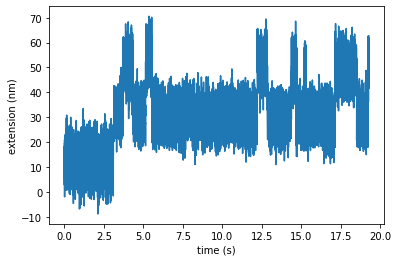

In [12]:
#Plotting the corrected extension vs. time
plt.plot(dat_corrected['time'],dat_corrected['drift_corrected'])
plt.ylabel('extension (nm)')
plt.xlabel('time (s)')

You can see that we obtained a flat signal without any drift. Now we can proceed to the data analysis.